In [239]:
import numpy as np
import pandas as pd
from constants import SHARED_RANDOM_STATE
from db_helper_functions import (
    get_stock_news_with_bertopic_sentiment_scores_from_db,
)

from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import GradientBoostingClassifier

from supervised_learning_data_preprocessing_functions import (
    gen_df_for_supervised_learning,
)
from grid_model_search_functions import (
    iterative_grid_cv_model_testing,
    grid_cv_test_model,
)
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ticker = "AAPL"

In [240]:
bert_topic_article_sentiment_df = gen_df_for_supervised_learning(
    ticker=ticker,
    sentiment_df_retrieval_function=get_stock_news_with_bertopic_sentiment_scores_from_db,
)
dataframes_to_test = [
    (bert_topic_article_sentiment_df, "bert_topic_article_sentiment_df"),
]

cv_train_size = [126]
cv_test_size = [31]
lag_time = [5]
tss_splits = 5
features_to_use = [
    "open",
    "prev_high",
    "prev_low",
    "prev_close",
    "positive",
    "negative",
    "neutral",
]


feature_to_predict = ["closed_higher"]
scoring_method = ["accuracy"]

param_grid = {
    "data_frame": dataframes_to_test,
    "cv_train_size": cv_train_size,
    "cv_test_size": cv_test_size,
    "lag_time": lag_time,
    "feature_to_predict": feature_to_predict,
    "scoring_method": scoring_method,
}
data_settings_grid_list = list(ParameterGrid(param_grid))

/Users/raulmartinez/Desktop/MADS/Milestone_2/w24-milestone2-team18-leevw-steveso-raulmart/.venv/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [241]:
gb_clf_results = iterative_grid_cv_model_testing(
    model=GradientBoostingClassifier(),
    model_parameters={
        "random_state": [SHARED_RANDOM_STATE],
        "learning_rate": [0.1, 0.2, 0.3, 0.4],
        "n_estimators": [5, 10, 20, 100],
        "max_depth": [None, 2, 5, 10, 15, 20],
        "max_leaf_nodes": [None, 2, 5, 10, 15, 20],
    },
    data_settings_grid_list=data_settings_grid_list,
    features_to_use=features_to_use,
    tss_splits=tss_splits,
)

In [242]:
gb_clf_results = gb_clf_results.sort_values(
    ["mean_test_score", "std_test_score"], ascending=[False, True]
)

### Failure Analysis


In [243]:
failure_analyis_best_model = grid_cv_test_model(
    model=GradientBoostingClassifier(),
    model_parameters={k[7:]: [v] for k, v in gb_clf_results.iloc[0].params.items()},
    data_frame=dataframes_to_test[0][0],
    features_to_use=features_to_use,
    feature_to_predict=feature_to_predict[0],
    scoring_method=scoring_method[0],
    cv_train_size=cv_train_size[0],
    cv_test_size=cv_test_size[0],
    lag_time=lag_time[0],
    num_tss_splits=tss_splits,
    return_model=True,
)

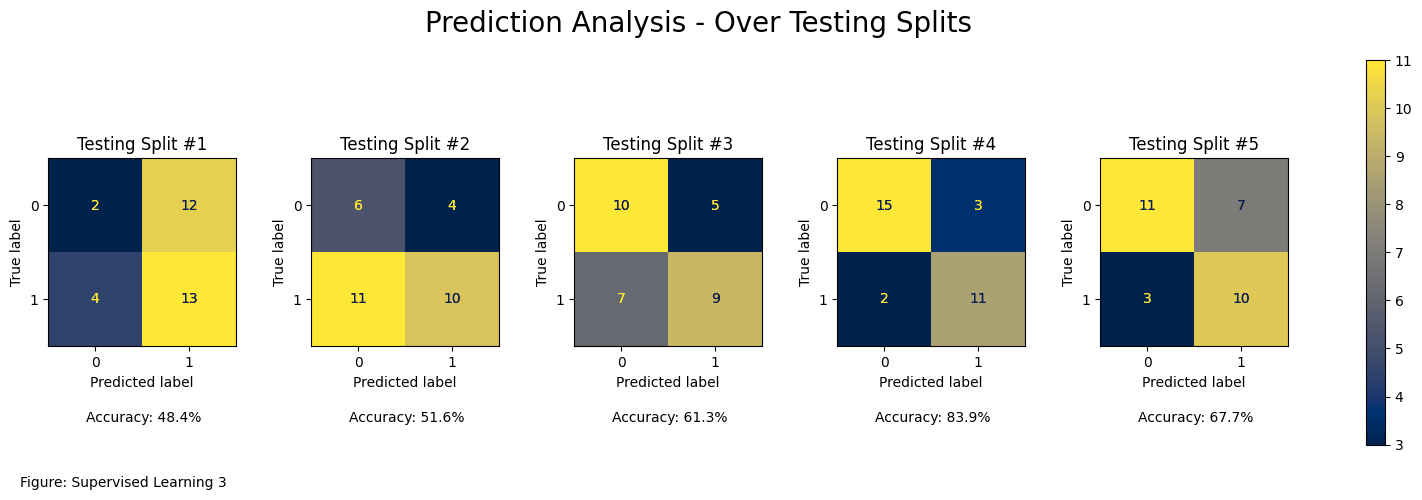

In [244]:
failure_analyis_gbc = failure_analyis_best_model.best_estimator_
failure_analysis_df = dataframes_to_test[0][0]

tss_splits = TimeSeriesSplit(
    n_splits=5,
    max_train_size=126,
    test_size=31,
    gap=5,
).split(bert_topic_article_sentiment_df)

splits_list = list(tss_splits)

f, axes = plt.subplots(1, 5, figsize=(20, 5))

for idx, split in enumerate(splits_list):
    training_indices = split[0]
    testing_indices = split[1]

    X_train = failure_analysis_df[features_to_use].iloc[training_indices]
    y_train = (
        failure_analysis_df[feature_to_predict]
        .iloc[training_indices]
        .to_numpy()
        .ravel()
    )

    failure_analyis_gbc.fit(X_train, y_train)

    X_test = failure_analysis_df[features_to_use].iloc[testing_indices]
    y_test = failure_analysis_df.closed_higher.iloc[testing_indices]
    y_pred = failure_analyis_gbc.predict(X_test)

    acc = np.round(np.round(accuracy_score(y_test, y_pred), 3) * 100, 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
    disp.plot(ax=axes[idx])
    disp.ax_.set_title(f"Testing Split #{idx+1}")
    disp.ax_.annotate(
        f"Accuracy: {acc}%",
        xy=(0, 0),
        xytext=(-0.1, 2.3),
        annotation_clip=False,
    )
    disp.im_.colorbar.remove()

    disp.plot(include_values=True, ax=axes[idx], colorbar=False, cmap="cividis")


plt.subplots_adjust(wspace=0.40, hspace=0.1)

f.colorbar(disp.im_, ax=axes)
f.suptitle("Prediction Analysis - Over Testing Splits", fontsize=20, x=0.45)

plt.text(-12, 3, "Figure: Supervised Learning 3")
plt.show()

In [248]:
failure_analyis_gbc = failure_analyis_best_model.best_estimator_
failure_analysis_df = dataframes_to_test[0][0]

tss_splits = TimeSeriesSplit(
    n_splits=5,
    max_train_size=126,
    test_size=31,
    gap=5,
).split(bert_topic_article_sentiment_df)

splits_list = list(tss_splits)

combo_corr_df = pd.DataFrame()

for idx, split in enumerate(splits_list):
    training_indices = split[0]
    testing_indices = split[1]

    X_train = failure_analysis_df[features_to_use].iloc[training_indices]
    y_train = (
        failure_analysis_df[feature_to_predict]
        .iloc[training_indices]
        .to_numpy()
        .ravel()
    )

    failure_analyis_gbc.fit(X_train, y_train)

    corr_df = pd.concat(
        [
            failure_analysis_df[["positive", "negative", "neutral", "closed_higher"]]
            .iloc[training_indices]
            .corr()[-1:]
            .reset_index(),
            failure_analysis_df[["positive", "negative", "neutral", "closed_higher"]]
            .iloc[testing_indices]
            .corr()[-1:]
            .reset_index(),
        ]
    )

    corr_df["index"] = idx + 1
    corr_df["data"] = ["train", "test"]
    corr_df.rename(columns={"index": "split"}, inplace=True)
    combo_corr_df = pd.concat([combo_corr_df, corr_df])

    X_test = failure_analysis_df[features_to_use].iloc[testing_indices]
    y_test = failure_analysis_df.closed_higher.iloc[testing_indices]
    y_pred = failure_analyis_gbc.predict(X_test)

    acc = np.round(np.round(accuracy_score(y_test, y_pred), 3) * 100, 1)

In [246]:
combo_corr_df[["split", "positive", "negative", "neutral"]].groupby(
    "split"
).diff().abs().dropna()

,positive,negative,neutral
0,0.284478,0.041255,0.384558
0,0.222122,0.062546,0.216321
0,0.120422,0.021850,0.165311
0,0.145551,0.002401,0.193255
0,0.054348,0.015665,0.035883


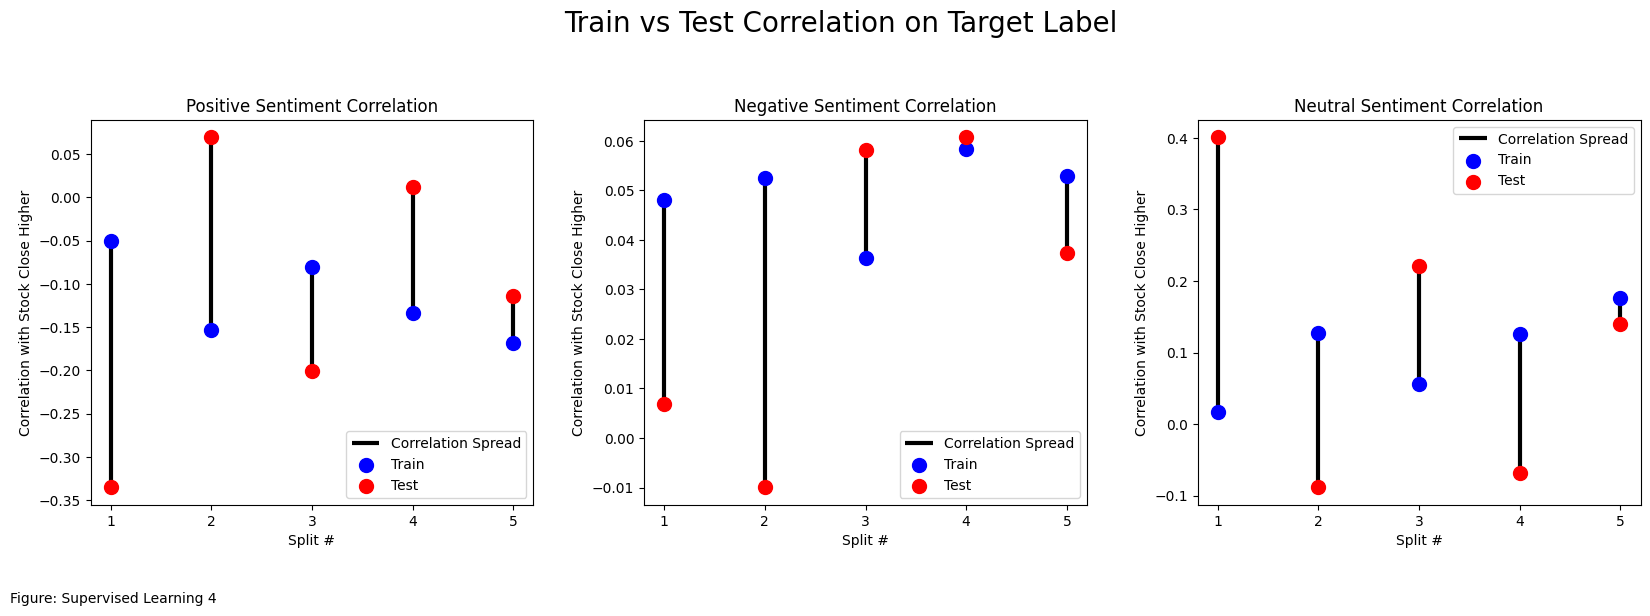

In [247]:
sentiments = ["positive", "negative", "neutral"]
f, axes = plt.subplots(1, 3, figsize=(20, 5))

for idx, sentiment in enumerate(sentiments):
    axes[idx].vlines(
        [1, 2, 3, 4, 5],
        combo_corr_df[combo_corr_df.data == "train"][sentiment],
        combo_corr_df[combo_corr_df.data == "test"][sentiment],
        color="black",
        linewidth=3,
    )

    axes[idx].scatter(
        [1, 2, 3, 4, 5],
        combo_corr_df[combo_corr_df.data == "train"][sentiment],
        color="blue",
        s=100,
        zorder=10,
    )
    axes[idx].scatter(
        [1, 2, 3, 4, 5],
        combo_corr_df[combo_corr_df.data == "test"][sentiment],
        color="red",
        s=100,
        zorder=10,
    )

    axes[idx].legend(["Correlation Spread", "Train", "Test"])
    axes[idx].set_xticks([1, 2, 3, 4, 5])
    axes[idx].set_xlabel("Split #")
    axes[idx].set_ylabel("Correlation with Stock Close Higher")
    axes[idx].title.set_text(f"{sentiment.capitalize()} Sentiment Correlation")


f.suptitle("Train vs Test Correlation on Target Label", fontsize=20, x=0.5, y=1.1)
plt.subplots_adjust(wspace=0.25, hspace=0.1)
plt.text(-11, -0.25, "Figure: Supervised Learning 4")

plt.show()